In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots

include("../helpers.jl");
include("../scalers.jl")
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_raw_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_raw_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_raw_df, y_raw_df = readjsonsfromdirectory(target_directory, x_raw_df, y_raw_df);

In [4]:
# some cuts
abnormally_high_rfq_length = 220. # OBJ3
abnormally_high_longitudinal_emittance = 0.2 # OBJ4
abnormally_high_x_emittance = 0.08 # OBJ5
abnormally_high_y_emittance = 0.08 # OBJ6

non_outlier_conditional = (y_raw_df[:, "OBJ3"] .<= abnormally_high_rfq_length) .&
    (y_raw_df[:, "OBJ4"] .<= abnormally_high_longitudinal_emittance) .&
    (y_raw_df[:, "OBJ5"] .<= abnormally_high_x_emittance) .&
    (y_raw_df[:, "OBJ6"] .<= abnormally_high_y_emittance)

# process data
x_outliers_df = x_raw_df[(!).(non_outlier_conditional), :];
y_outliers_df = y_raw_df[(!).(non_outlier_conditional), :];

x_df = x_raw_df[non_outlier_conditional, :];
y_df = y_raw_df[non_outlier_conditional, :];

In [5]:
sum((!).(non_outlier_conditional))

717

## Data preprocessing

In [16]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)
y_scaled_df = minmaxscaledf(y_df)

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

In [18]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [19]:
# format to arrays
x_train = Matrix(x_train_df); x_test = Matrix(x_test_df);
y_train = Matrix(y_train_df); y_test = Matrix(y_test_df);

In [20]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Building and training the neural net

In [21]:
# some other loss functions / metrics
max_valueormachinelimit(x) = max(x, eps())

# build the model
function neuralnetwork()
    Chain(
        Dense(x_dimension, 150, x->relu(x)),
        Dense(150, 150, x->relu(x)),
        Dense(150, 150, x->relu(x)),
        Dense(150, y_dimension)
    )
end

neuralnetwork (generic function with 1 method)

In [22]:
# organizing data into batches
batch_size = 32
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [25]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM(0.0001)
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 250
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=75.91588790435344
epoch 2, loss=63.807436984963715
epoch 3, loss=60.13814216060564
epoch 4, loss=55.612969131208956
epoch 5, loss=53.41463973512873
epoch 6, loss=52.743717916775495
epoch 7, loss=51.874661044217646
epoch 8, loss=51.25808674143627
epoch 9, loss=49.78347576688975
epoch 10, loss=49.65536801330745
epoch 11, loss=50.14479107409716
epoch 12, loss=48.831702205352485
epoch 13, loss=49.005782448221
epoch 14, loss=48.66501030744985
epoch 15, loss=48.2412709062919
epoch 16, loss=47.61043729074299
epoch 17, loss=47.87354564713314
epoch 18, loss=48.509371616411954
epoch 19, loss=47.600525725167245
epoch 20, loss=47.104455307126045
epoch 21, loss=46.64859266253188
epoch 22, loss=47.27756331209093
epoch 23, loss=46.10435718484223
epoch 24, loss=46.39776528859511
epoch 25, loss=46.01036067632958
epoch 26, loss=45.63648223504424
epoch 27, loss=45.558394476771355
epoch 28, loss=45.46294699655846
epoch 29, loss=45.79376895679161
epoch 30, loss=45.51547476556152
epoch 31, los

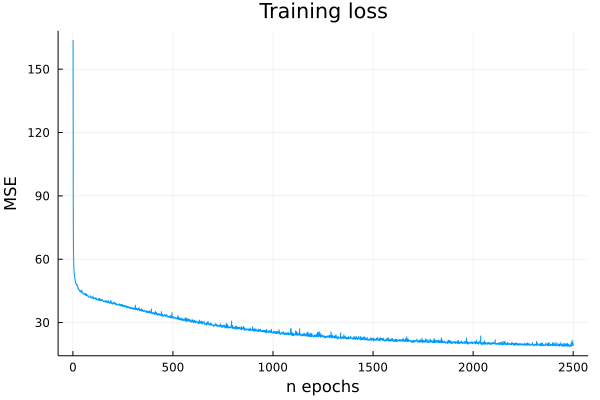

In [45]:
# plot training history
plot(epochs, training_losses; title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false)

## Model evaluation

In [46]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [47]:
r2_train = r2score_multidim(y_train, m(x_train')')
r2_test = r2score_multidim(y_test, m(x_test')')
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

r2 on training set: 0.97064424
r2 on test set: 0.89647746


In [48]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 4 methods)

In [49]:
size(x_train, 2)

14

In [50]:
adjustedr2_train = adjustedr2score_multidim(y_train, m(x_train')', size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, m(x_test')', size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

adjustedr2 on training set: 0.97064185
adjustedr2 on test set: 0.8964439


In [51]:
mae_train = Flux.mae(m(x_train')', y_train)
mae_test = Flux.mae(m(x_test')', y_test)
println("mae on training set: $mae_train")
println("mae on test set: $mae_test")

mae on training set: 0.04163592
mae on test set: 0.06815951


In [52]:
# mae for each response
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

for i in 1:y_dimension
    mae_train_by_dim = Flux.mae(y_train_preds[:,i], y_train[:, i])
    mae_test_by_dim = Flux.mae(y_test_preds[:, i], y_test[:, i])
    println("mae on training set for OBJ$i: $mae_train_by_dim")
    println("mae on test set for OBJ$i: $mae_test_by_dim")
end

mae on training set for OBJ1: 0.019589616
mae on test set for OBJ1: 0.022494685
mae on training set for OBJ2: 0.070856266
mae on test set for OBJ2: 0.07624518
mae on training set for OBJ3: 0.013884842
mae on test set for OBJ3: 0.014671298
mae on training set for OBJ4: 0.030780029
mae on test set for OBJ4: 0.03670172
mae on training set for OBJ5: 0.058974065
mae on test set for OBJ5: 0.13045165
mae on training set for OBJ6: 0.055730708
mae on test set for OBJ6: 0.12839255


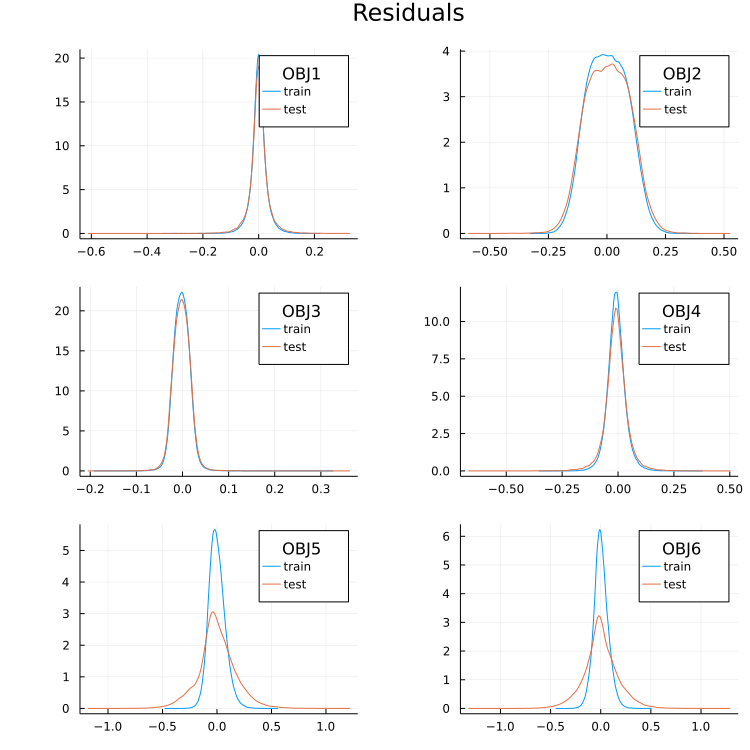

In [53]:
# plotting the residual distribution
l = @layout [grid(3,2)]

y_columns = names(y_df)
residuals_train = y_train - m(x_train')'
residuals_test = y_test - m(x_test')'

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = density(
        residuals_train[:, i];
        xlabel="", ylabel="", label="train", legend=true, legendtitle="    $colname", left_margin = 12Plots.mm
    )
    density!(sp, residuals_test[:, i]; xlabel="", ylabel="", label="test", legend=true)
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(750, 750), plot_title="Residuals")

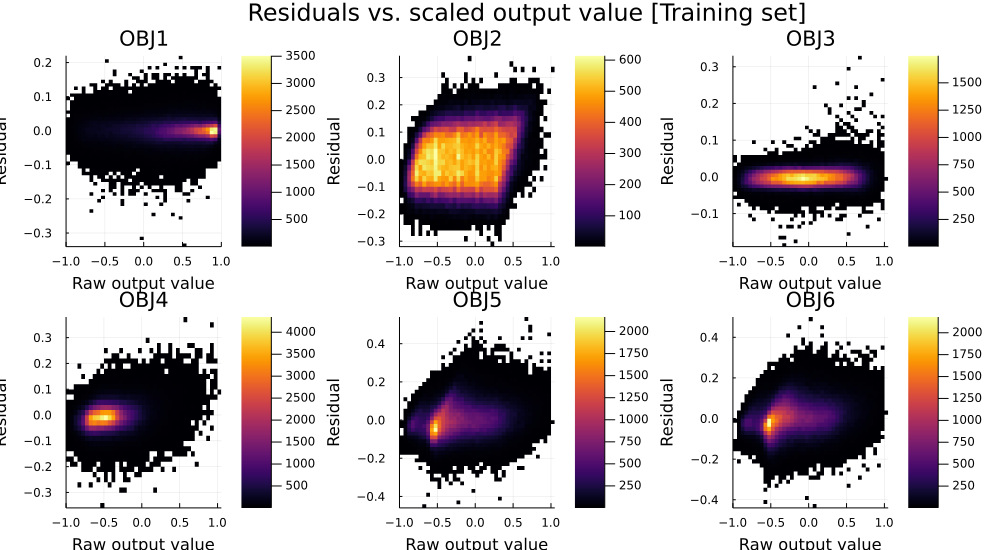

In [54]:
# residuals as a function of scaled objective value
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_train[:, i], residuals_train[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Training set]")

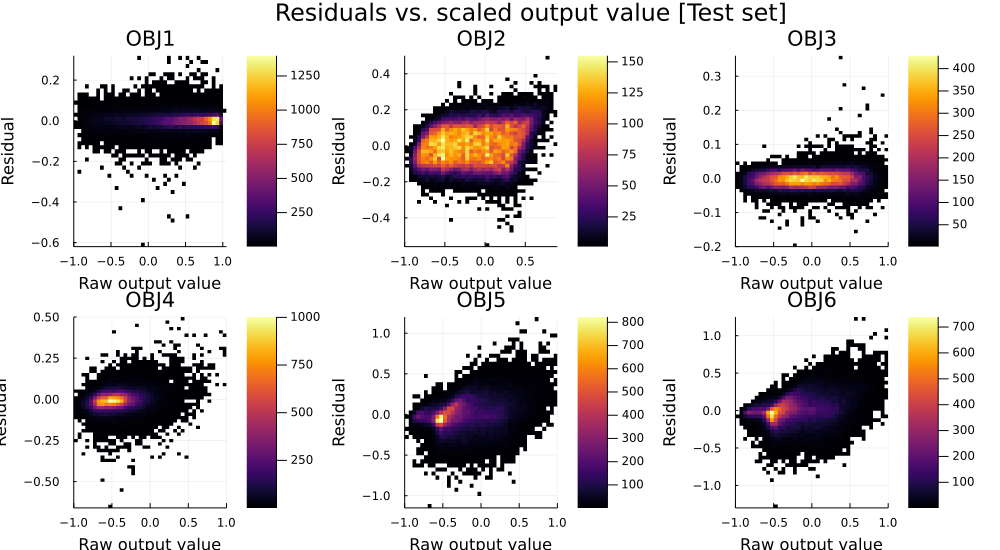

In [55]:
# residuals as a function of scaled objective value, test set
l = @layout [grid(2,3)]

subplots = []
for (i, colname) in enumerate(y_columns)
    sp = histogram2d(
        y_test[:, i], residuals_test[:, i];
        xlabel="Raw output value", ylabel="Residual", label="train", legend=true,
        title="$colname", bins=(60, 60)
    )
    push!(subplots, sp)
end

plot(subplots..., layout = l, size=(1000, 550), plot_title="Residuals vs. scaled output value [Test set]")

## Creating Hierarchical Neural Networks

For a proof-of-concept, I choose Energy (Objective 2).

For each input $\mathbf{x}_i \in \mathbb{R}^{14}$, our neural network created above is a function $\mathbf{f}$ such that we can generate predictions $\hat{\mathbf{y}}_i = \mathbf{f}(\mathbf{x}_i), \mathbf{y}_i \in \mathbb{R}^6$. This neural network was trained to minimize the mean squared error $\sum_i (\mathbf{y}_i - \hat{\mathbf{y}}_i)^2$.

Now I create a second neural network with inputs $\mathbf{x}_i, \hat{y}_{i}$, where $\hat{y}_i$ is the prediction from the first neural network.

In [50]:
component = 2
v_dimension = 20 # can automate later

# build the model
function energyneuralnetwork()
    Chain(
        Dense(v_dimension, 10, x->σ.(x)),
        Dense(10, 10, x->σ.(x)),
        Dense(10, 5, x->σ.(x)),
        Dense(5, 5, x->σ.(x)),
        Dense(5, 1)
    )
end

energyneuralnetwork (generic function with 1 method)

In [51]:
# make data
v_train = hcat(x_train, y_train_preds);
v_test = hcat(x_test, y_test_preds);

y2_train = y_train[:, component];
y2_test = y_train[:, component];

In [54]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((v_train', y2_train'), batchsize=batch_size, shuffle=true);

In [60]:
# defining our model, optimization algorithm and loss function
m2 = energyneuralnetwork()
optimizer = ADAM(0.0001)
loss(x, y) = Flux.mse(m2(x), y)

# training
n_epochs = 2500
training_losses_2 = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m2), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses_2, l)
end

epoch 1, loss=46.83430635929108
epoch 2, loss=38.23272742331028
epoch 3, loss=32.642766177654266
epoch 4, loss=29.18400551378727
epoch 5, loss=27.155325159430504
epoch 6, loss=26.053116396069527
epoch 7, loss=25.487312227487564
epoch 8, loss=25.207911908626556
epoch 9, loss=25.063347339630127
epoch 10, loss=24.992431208491325
epoch 11, loss=24.955397680401802
epoch 12, loss=24.88528111577034
epoch 13, loss=24.823585763573647
epoch 14, loss=24.75417585670948
epoch 15, loss=24.635499015450478
epoch 16, loss=24.509068712592125
epoch 17, loss=24.3161474019289
epoch 18, loss=24.097461864352226
epoch 19, loss=23.812099188566208
epoch 20, loss=23.438204258680344
epoch 21, loss=22.993608564138412
epoch 22, loss=22.410315342247486
epoch 23, loss=21.71584353595972
epoch 24, loss=20.890567667782307
epoch 25, loss=19.89965406805277
epoch 26, loss=18.745666056871414
epoch 27, loss=17.43566645681858
epoch 28, loss=15.973066344857216
epoch 29, loss=14.402847595512867
epoch 30, loss=12.745964638888836

epoch 241, loss=1.3869976731948555
epoch 242, loss=1.3859670888632536
epoch 243, loss=1.3865423328243196
epoch 244, loss=1.3854623581282794
epoch 245, loss=1.3855159026570618
epoch 246, loss=1.3862775014713407
epoch 247, loss=1.3849786715582013
epoch 248, loss=1.3852071478031576
epoch 249, loss=1.384435030631721
epoch 250, loss=1.3855013232678175
epoch 251, loss=1.3844850976020098
epoch 252, loss=1.3859708146192133
epoch 253, loss=1.3852914203889668
epoch 254, loss=1.3845462775789201
epoch 255, loss=1.3855743892490864
epoch 256, loss=1.384532987140119
epoch 257, loss=1.3847559811547399
epoch 258, loss=1.3855700148269534
epoch 259, loss=1.3841609111987054
epoch 260, loss=1.3840306694619358
epoch 261, loss=1.3838118785060942
epoch 262, loss=1.3831100431270897
epoch 263, loss=1.3833450772799551
epoch 264, loss=1.3824678640812635
epoch 265, loss=1.3835657611489296
epoch 266, loss=1.385003058705479
epoch 267, loss=1.3843374960124493
epoch 268, loss=1.3835783936083317
epoch 269, loss=1.38466

epoch 477, loss=1.3697134763933718
epoch 478, loss=1.369530776515603
epoch 479, loss=1.3689629775471985
epoch 480, loss=1.3699091426096857
epoch 481, loss=1.3687063264660537
epoch 482, loss=1.3693795925937593
epoch 483, loss=1.3707515257410705
epoch 484, loss=1.369555272627622
epoch 485, loss=1.3690375881269574
epoch 486, loss=1.3716504164040089
epoch 487, loss=1.369017580524087
epoch 488, loss=1.3681819676421583
epoch 489, loss=1.3705687709152699
epoch 490, loss=1.370611606631428
epoch 491, loss=1.3686317158862948
epoch 492, loss=1.3692493787966669
epoch 493, loss=1.3686350514180958
epoch 494, loss=1.3684263937175274
epoch 495, loss=1.368754361756146
epoch 496, loss=1.3695356366224587
epoch 497, loss=1.3689584042876959
epoch 498, loss=1.3688104711472988
epoch 499, loss=1.3683171169832349
epoch 500, loss=1.3694746787659824
epoch 501, loss=1.3688994543626904
epoch 502, loss=1.3685693657025695
epoch 503, loss=1.371847540140152
epoch 504, loss=1.3677508854307234
epoch 505, loss=1.36789435

epoch 713, loss=1.3624764028936625
epoch 714, loss=1.3632144634611905
epoch 715, loss=1.362453367561102
epoch 716, loss=1.3620811305008829
epoch 717, loss=1.3626678357832134
epoch 718, loss=1.3619990507140756
epoch 719, loss=1.3626851863227785
epoch 720, loss=1.3623560559935868
epoch 721, loss=1.3624798217788339
epoch 722, loss=1.3628717339597642
epoch 723, loss=1.3621942191384733
epoch 724, loss=1.3618915998376906
epoch 725, loss=1.3619716418907046
epoch 726, loss=1.3624557345174253
epoch 727, loss=1.3619749383069575
epoch 728, loss=1.3643002826720476
epoch 729, loss=1.3622116004116833
epoch 730, loss=1.3627153430134058
epoch 731, loss=1.3622187552973628
epoch 732, loss=1.3616668498143554
epoch 733, loss=1.3616908895783126
epoch 734, loss=1.362507986370474
epoch 735, loss=1.3639867915771902
epoch 736, loss=1.3613203973509371
epoch 737, loss=1.3630486414767802
epoch 738, loss=1.3636502432636917
epoch 739, loss=1.363199456129223
epoch 740, loss=1.3614260973408818
epoch 741, loss=1.36418

epoch 949, loss=1.3611775897443295
epoch 950, loss=1.360891010146588
epoch 951, loss=1.3602616875432432
epoch 952, loss=1.3618441186845303
epoch 953, loss=1.3601822457276285
epoch 954, loss=1.3607602342963219
epoch 955, loss=1.3608212056569755
epoch 956, loss=1.3635407853871584
epoch 957, loss=1.3613221538253129
epoch 958, loss=1.3606715919449925
epoch 959, loss=1.3598728273063898
epoch 960, loss=1.3601644891314209
epoch 961, loss=1.3613447593525052
epoch 962, loss=1.3611291982233524
epoch 963, loss=1.3602604451589286
epoch 964, loss=1.3618516852147877
epoch 965, loss=1.3609920414164662
epoch 966, loss=1.359732335433364
epoch 967, loss=1.3618447133339942
epoch 968, loss=1.3614231920801103
epoch 969, loss=1.3622089778073132
epoch 970, loss=1.3609886295162141
epoch 971, loss=1.360634611453861
epoch 972, loss=1.360558264888823
epoch 973, loss=1.3619403904303908
epoch 974, loss=1.3623016346246004
epoch 975, loss=1.3614811757579446
epoch 976, loss=1.3602387737482786
epoch 977, loss=1.361602

epoch 1407, loss=1.3597917510196567
epoch 1408, loss=1.3592856102623045
epoch 1409, loss=1.36059297202155
epoch 1410, loss=1.3599201212637126
epoch 1411, loss=1.3599990424700081
epoch 1412, loss=1.3605828299187124
epoch 1413, loss=1.3597614127211273
epoch 1414, loss=1.3600301803089678
epoch 1415, loss=1.3602202921174467
epoch 1416, loss=1.3602230264805257
epoch 1417, loss=1.3599309441633523
epoch 1418, loss=1.3594754105433822
epoch 1419, loss=1.359557838179171
epoch 1420, loss=1.3608156768605113
epoch 1421, loss=1.3594874353148043
epoch 1422, loss=1.3600285155698657
epoch 1423, loss=1.3592142025008798
epoch 1424, loss=1.3615557858720422
epoch 1425, loss=1.3604331011883914
epoch 1426, loss=1.36062424024567
epoch 1427, loss=1.3593175997957587
epoch 1428, loss=1.3595880172215402
epoch 1429, loss=1.3598204385489225
epoch 1430, loss=1.360561071895063
epoch 1431, loss=1.359536646399647
epoch 1432, loss=1.3603909160010517
epoch 1433, loss=1.3597196978516877
epoch 1434, loss=1.3599278717301786

epoch 1865, loss=1.3624263098463416
epoch 1866, loss=1.359336858149618
epoch 1867, loss=1.3587264218367636
epoch 1868, loss=1.360287383198738
epoch 1869, loss=1.3590915482491255
epoch 1870, loss=1.360365504398942
epoch 1871, loss=1.3595433640293777
epoch 1872, loss=1.3595100226812065
epoch 1873, loss=1.36243543215096
epoch 1874, loss=1.359244062565267
epoch 1875, loss=1.3606089986860752
epoch 1876, loss=1.3604063400998712
epoch 1877, loss=1.359277032315731
epoch 1878, loss=1.3632569191977382
epoch 1879, loss=1.3597975512966514
epoch 1880, loss=1.3597375890240073
epoch 1881, loss=1.3598936684429646
epoch 1882, loss=1.359918616246432
epoch 1883, loss=1.362473685760051
epoch 1884, loss=1.36092440597713
epoch 1885, loss=1.3593373191542923
epoch 1886, loss=1.3598734443075955
epoch 1887, loss=1.3619015226140618
epoch 1888, loss=1.360607490874827
epoch 1889, loss=1.359585425350815
epoch 1890, loss=1.3595639425329864
epoch 1891, loss=1.3613189053721726
epoch 1892, loss=1.3596045556478202
epoch

epoch 2095, loss=1.3604182181879878
epoch 2096, loss=1.3599880682304502
epoch 2097, loss=1.3603455214761198
epoch 2098, loss=1.3597172116860747
epoch 2099, loss=1.3587554227560759
epoch 2100, loss=1.3591127037070692
epoch 2101, loss=1.3599052662029862
epoch 2102, loss=1.3602171721868217
epoch 2103, loss=1.3598146056756377
epoch 2104, loss=1.3596593048423529
epoch 2105, loss=1.3598520471714437
epoch 2106, loss=1.360008322633803
epoch 2107, loss=1.3613902307115495
epoch 2108, loss=1.3587203077040613
epoch 2109, loss=1.3592639002017677
epoch 2110, loss=1.3583126584999263
epoch 2111, loss=1.3586845337413251
epoch 2112, loss=1.3600125662051141
epoch 2113, loss=1.3605005708523095
epoch 2114, loss=1.3589121904224157
epoch 2115, loss=1.3598812413401902
epoch 2116, loss=1.3598157628439367
epoch 2117, loss=1.3613512651063502
epoch 2118, loss=1.35992397274822
epoch 2119, loss=1.3590178992599249
epoch 2120, loss=1.3596390602178872
epoch 2121, loss=1.3596149175427854
epoch 2122, loss=1.359356494154

In [69]:
# before second neural network
r2_train_2 = r2score(y_train[:,component], m(x_train')'[:, component])
r2_test_2 = r2score(y_test[:, component], m(x_test')'[:, component])
println("r2 on training set: $r2_train_2")
println("r2 on test set: $r2_test_2")
# after second neural network
println("after second nn")
r2_train_custom2 = r2score(y_train[:,component], m2(v_train')')
r2_test_custom2 = r2score(y_test[:, component], m2(v_test')')
println("r2 on training set: $r2_train_custom2")
println("r2 on test set: $r2_test_custom2")

r2 on training set: 0.94569165
r2 on test set: 0.9458492
after second nn
r2 on training set: 0.9461484
r2 on test set: 0.9463336


In [72]:
# before second neural network
mae_train_by_dim = Flux.mae(y_train_preds[:,component], y_train[:, component])
mae_test_by_dim = Flux.mae(y_test_preds[:, component], y_test[:, component])
println("mae on training set for OBJ2: $mae_train_by_dim")
println("mae on test set for OBJ2: $mae_test_by_dim")

# after
println("after second nn")
mae_train_by_dim = Flux.mae(m2(v_train')', y_train[:, component])
mae_test_by_dim = Flux.mae(m2(v_test')', y_test[:, component])
println("mae on training set for OBJ2: $mae_train_by_dim")
println("mae on test set for OBJ2: $mae_test_by_dim")

mae on training set for OBJ2: 0.07478682
mae on test set for OBJ2: 0.074942224
after second nn
mae on training set for OBJ2: 0.074517354
mae on test set for OBJ2: 0.07461379
